# K-Means Clustering Analysis of Customer Data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

In [19]:
# load the data
customers_df = pd.read_csv("customers.csv")
numerical_features = ['Age', 'Income', 'Score']

# Z-score normalization
scaler = StandardScaler()
customers_df[['Age_n', 'Income_n', 'Score_n']] = scaler.fit_transform(customers_df[numerical_features])

customers_df.head()

,ID,Gender,Age,Income,Score,Age_n,Income_n,Score_n
0,1,Male,19,15,39,-1.424569,-1.738999,-0.434801
1,2,Male,21,15,81,-1.281035,-1.738999,1.195704
2,3,Female,20,16,6,-1.352802,-1.700830,-1.715913
3,4,Female,23,16,77,-1.137502,-1.700830,1.040418
4,5,Female,31,17,40,-0.563369,-1.662660,-0.395980


I start by performing K-means with different k values, k = 2,3,...,10. In computing the distance, I use only the normalised features. I then calculate the best k.

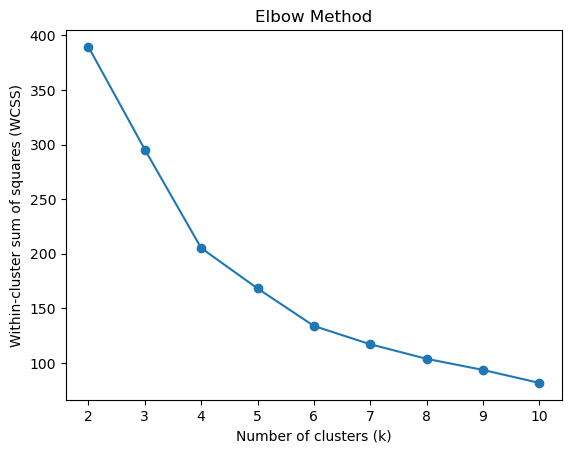

In [21]:
# List to store the within-cluster sum of squares (WCSS) for different k values
sum_of_squares = []
n_features = customers_df[['Age_n', 'Income_n', 'Score_n']]

# Iterate over different values of k from 2 to 10
for k in range(2, 11):
    # Create KMeans instance with k clusters and fit it to the normalized data
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(n_features)
    sum_of_squares.append(kmeans.inertia_)

# Plot the WCSS values for different k values
plt.plot(range(2, 11), sum_of_squares, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.show()

The optimal k value is where the plot starts to flatten out, indicating diminishing returns in terms of reducing WCSS with additional clusters. This point is known as the "elbow point", in our graph it corresponds to k = 6. The reason why we have chosen k = 6 instead of k = 4 is because after k = 6 it starts to decrease more slowly.

Moreover, in order to prove our assumption mathematically, we decided to apply the silhouette score method to our algorithm. Indeed, it is less subjective than the elbow method, as it provides an individual score for each node based on the average distance to every other data point within the cluster and the distance with the data points from the nearest cluster. The silhouette score corresponds to the average of each individual score to obtain an overall score for the clustering. It is a useful tool for determining the optimal number of clusters in a dataset.

In [22]:
# Silhouette score method for selecting the optimal number of clusters (k)
# I added this method to confirm that my intuition from looking at the graph was correct

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customers_df[numerical_features])
    # Compute silhouette score
    silhouette_avg = silhouette_score(customers_df[numerical_features], labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters (k)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters (k):", optimal_k)

Optimal number of clusters (k): 6


The result obtained confirms that the best k is 6.

For better interpretation I cluster the samples using K-means with the best k and plot the clusters and centroids in 3D with denormalised axes.

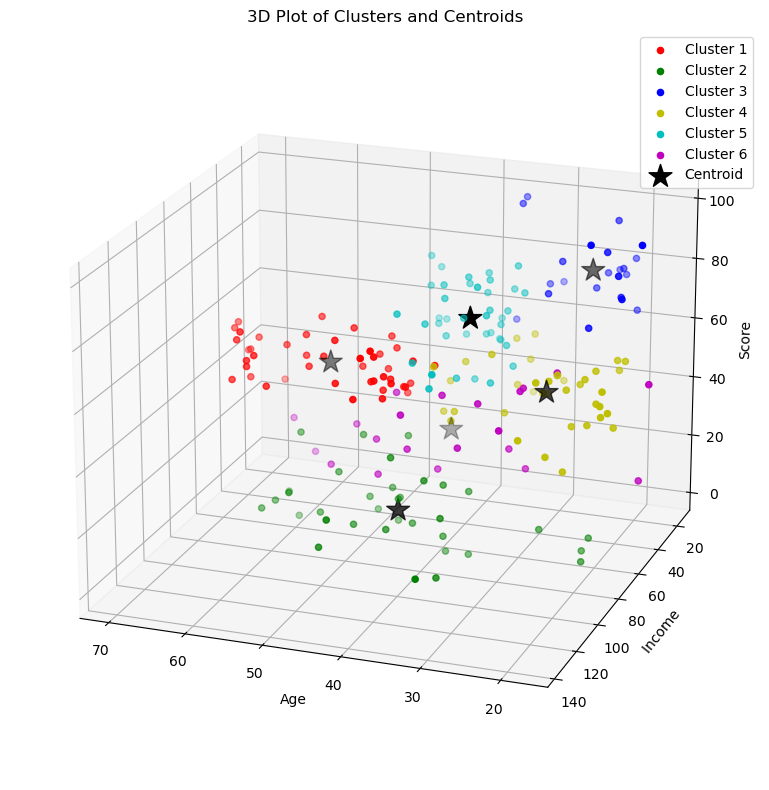

In [23]:
k = 6  

# Using Age, Income, and Score directly for clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(customers_df[numerical_features])
customers_df['Cluster'] = kmeans.labels_

# 3D Plotting
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'brown', 'grey', 'pink']

# Plot each cluster
for i in range(k):
    ax.scatter(customers_df.loc[customers_df['Cluster'] == i, 'Age'],
               customers_df.loc[customers_df['Cluster'] == i, 'Income'],
               customers_df.loc[customers_df['Cluster'] == i, 'Score'],
               c=colors[i], label=f'Cluster {i+1}')

# Plot centroids
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
           s=300, marker='*', c='black', label='Centroid')
ax.view_init(elev=20, azim=110)
ax.set_xlabel('Age')
ax.set_ylabel('Income ')
ax.set_zlabel('Score')
plt.title('3D Plot of Clusters and Centroids')
plt.tight_layout()
plt.legend()
plt.show()

The figure shows K-means clustering on the normalized numerical features (Age, Income, Score) with k = 6 in 3D. The 6 clusters are ploted in different colors and each has a centroid. The clusters 1(red), 3(blue), 4(yellow), 5(lightblue) are clearly apart from the other clusters, with very few points overlapping with the rest of the data, hence we can say that these are clear customer segments.

However, when it comes to clusters 2(green), 6(purple) we see more dots spread around the Age-Income dimensions, which means that these pair of clusters or customer segments may vary in terms of income and age share similar characteristic in score.

---

Now, I will create three different datasets, each with two out of the three features I normalised, i.e. (age,income), (age, score), (income, score). I will then perform K-means and find the best k for each of them.

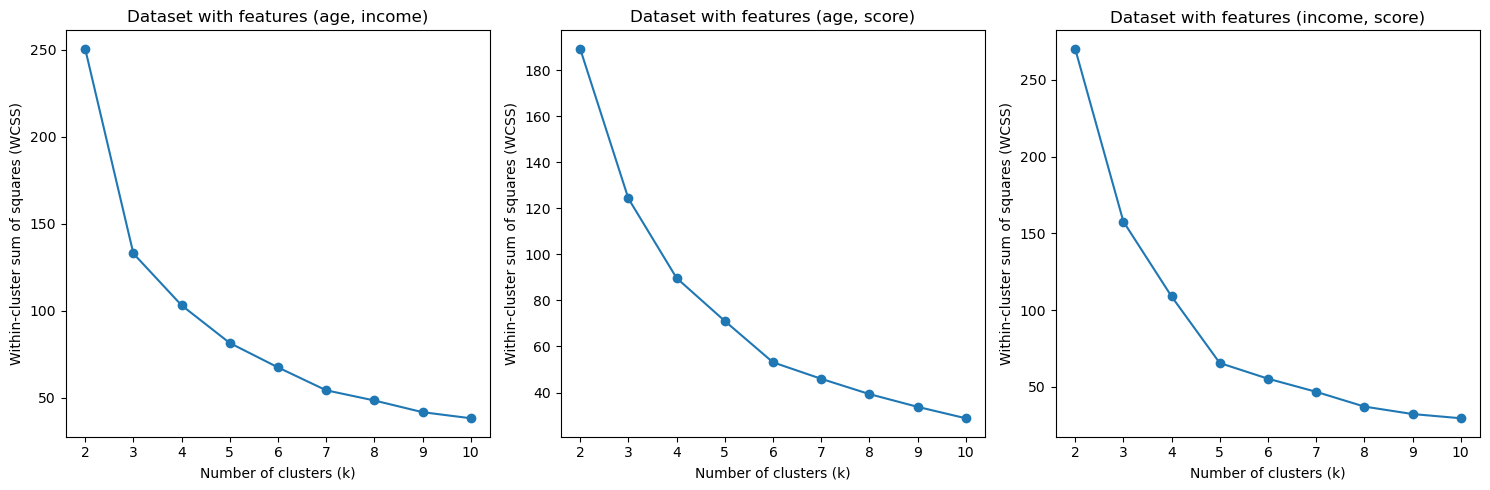

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Dataset with features (age, income)
dataset_age_income = customers_df[['Age_n', 'Income_n']]

list1 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dataset_age_income)
    list1.append(kmeans.inertia_)
axes[0].plot(range(2, 11), list1, marker='o')
axes[0].set_title('Dataset with features (age, income)')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Within-cluster sum of squares (WCSS)')

# Dataset with features (age, score)
dataset_age_score = customers_df[['Age_n','Score_n']]

list2 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dataset_age_score)
    list2.append(kmeans.inertia_)
axes[1].plot(range(2, 11), list2, marker='o')
axes[1].set_title('Dataset with features (age, score)')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Within-cluster sum of squares (WCSS)')

# Dataset with features (income, score)
dataset_income_score = customers_df[['Income_n', 'Score_n']]

list3 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dataset_income_score)
    list3.append(kmeans.inertia_)
axes[2].plot(range(2, 11), list3, marker='o')
axes[2].set_title('Dataset with features (income, score)')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Within-cluster sum of squares (WCSS)')

plt.tight_layout()
plt.show()

Dataset with features (age, income) -> Best k = 3 (there are three well-separated clusters in the data, based on the age and income features)

Dataset with features (age, score) -> Best k = 2 (there are two well-separated clusters in the data, based on the age and score features)

Dataset with features (income, score) -> Best k = 5 (there are five well-separated clusters in the data, based on the income and score features)


Let's again prove our assumptions from the graph using the silhouette score method:

In [25]:
silhouette_scores_1 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(dataset_age_income)
    silhouette_avg_1 = silhouette_score(dataset_age_income, labels)
    silhouette_scores_1.append(silhouette_avg_1)

# Find the optimal number of clusters (k)
optimal_k = silhouette_scores_1.index(max(silhouette_scores_1)) + 2
print("Optimal number of clusters (k) for dataset (age, income):", optimal_k)

silhouette_scores_2 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(dataset_age_score)
    silhouette_avg_2 = silhouette_score(dataset_age_score, labels)
    silhouette_scores_2.append(silhouette_avg_2)

# Find the optimal number of clusters (k)
optimal_k = silhouette_scores_2.index(max(silhouette_scores_2)) + 2
print("Optimal number of clusters (k) for dataset (age, score):", optimal_k)

silhouette_scores_3 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(dataset_income_score)
    silhouette_avg_3 = silhouette_score(dataset_income_score, labels)
    silhouette_scores_3.append(silhouette_avg_3)

# Find the optimal number of clusters (k)
optimal_k = silhouette_scores_3.index(max(silhouette_scores_3)) + 2
print("Optimal number of clusters (k) for dataset (income, score):", optimal_k)

Optimal number of clusters (k) for dataset (age, income): 3
Optimal number of clusters (k) for dataset (age, score): 2
Optimal number of clusters (k) for dataset (income, score): 5


I will continue by plotting the clusters and distinguish the data points based on the 'Gender' categorical feature. The objective is to recognize customer segments.

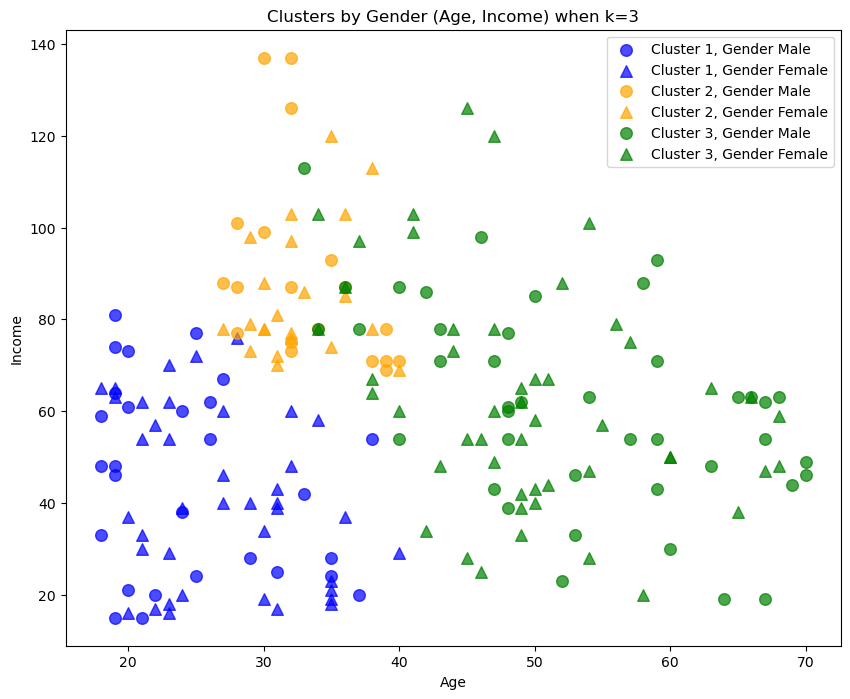

In [26]:
# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(n_features)

# Create a DataFrame with the cluster labels and Gender
cluster_df = pd.DataFrame({'Cluster': labels, 'Gender': customers_df['Gender'], 'Age': customers_df['Age'], 'Income': customers_df['Income']})

# Plot the clusters based on Gender
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure(figsize=(10, 8))
for cluster, color in zip(range(3), cluster_colors):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster]
    for gender, marker in zip(['Male', 'Female'], ['o', '^']):
        gender_data = cluster_data[cluster_data['Gender'] == gender]
        plt.scatter(gender_data['Age'], gender_data['Income'], color=color, marker=marker, label=f'Cluster {cluster + 1}, Gender {gender}', alpha=0.7, s=70)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Clusters by Gender (Age, Income) when k=3')
plt.legend()
plt.show()

In [27]:
# Distribution of data point by gender and cluster (age, income)
for cluster in range(3):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster]
    for gender in ['Male', 'Female']:
        gender_data = cluster_data[cluster_data['Gender'] == gender]
        print(f'Cluster {cluster + 1}, Gender {gender}: {len(gender_data)} data points')

Cluster 1, Gender Male: 28 data points
Cluster 1, Gender Female: 40 data points
Cluster 2, Gender Male: 19 data points
Cluster 2, Gender Female: 22 data points
Cluster 3, Gender Male: 41 data points
Cluster 3, Gender Female: 50 data points


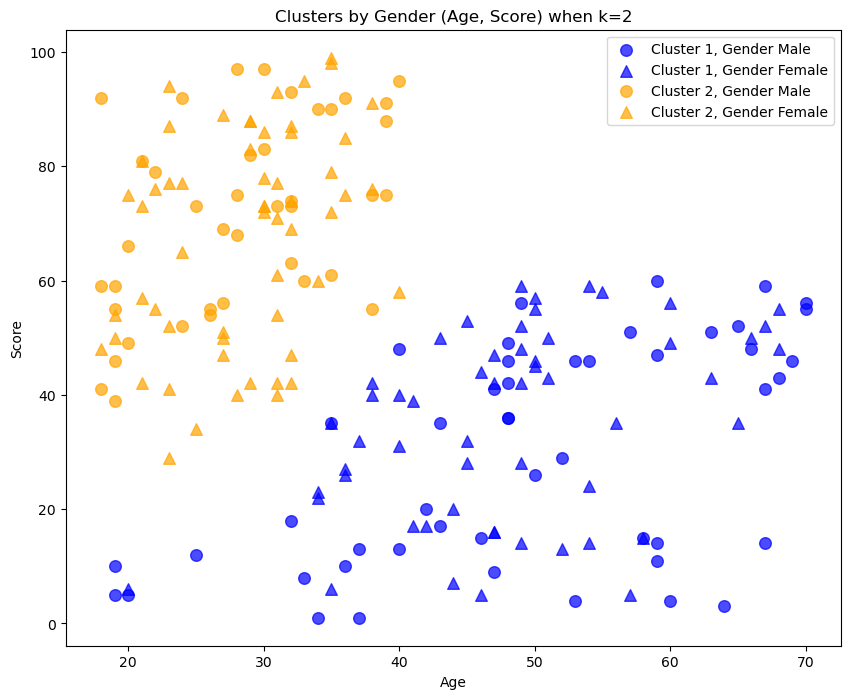

In [29]:
# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(n_features)

# Create a DataFrame with the cluster labels and Gender
cluster_df = pd.DataFrame({'Cluster': labels, 'Gender': customers_df['Gender'], 'Age': customers_df['Age'], 'Score': customers_df['Score']})

# Plot the clusters based on Gender
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure(figsize=(10, 8))
for cluster, color in zip(range(2), cluster_colors):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster]
    for gender, marker in zip(['Male', 'Female'], ['o', '^']):
        gender_data = cluster_data[cluster_data['Gender'] == gender]
        plt.scatter(gender_data['Age'], gender_data['Score'], color=color, marker=marker, label=f'Cluster {cluster + 1}, Gender {gender}', alpha=0.7, s=70)
plt.xlabel('Age')
plt.ylabel('Score')
plt.title('Clusters by Gender (Age, Score) when k=2')
plt.legend()
plt.show()

In [30]:
# Distribution of data point by gender and cluster (age, score)
for cluster in range(2):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster]
    for gender in ['Male', 'Female']:
        gender_data = cluster_data[cluster_data['Gender'] == gender]
        print(f'Cluster {cluster + 1}, Gender {gender}: {len(gender_data)} data points')

Cluster 1, Gender Male: 48 data points
Cluster 1, Gender Female: 55 data points
Cluster 2, Gender Male: 40 data points
Cluster 2, Gender Female: 57 data points


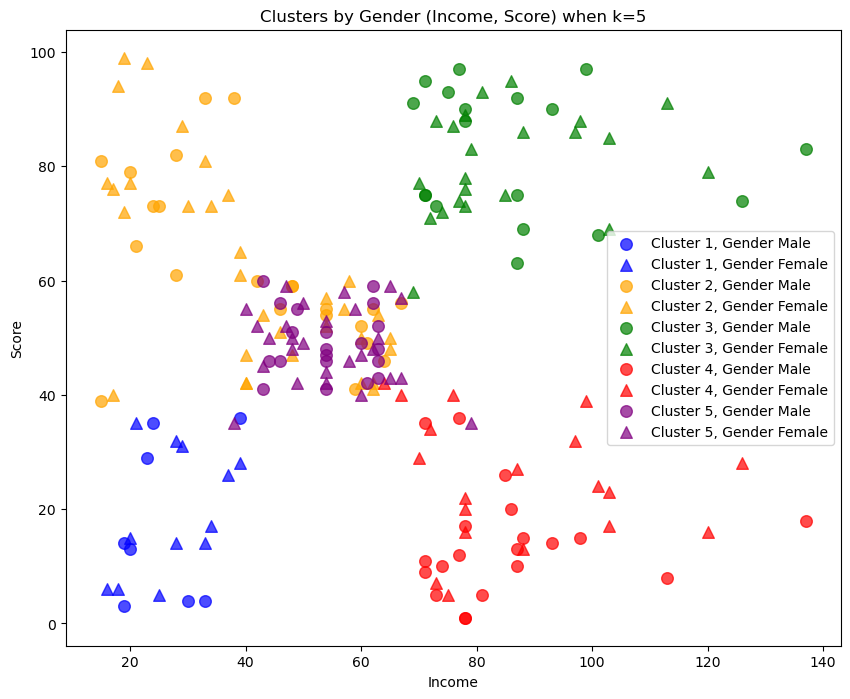

In [31]:
# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(n_features)

# Create a DataFrame with the cluster labels and Gender
cluster_df = pd.DataFrame({'Cluster': labels, 'Gender': customers_df['Gender'], 'Income': customers_df['Income'], 'Score': customers_df['Score']})

# Plot the clusters based on Gender
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure(figsize=(10, 8))
for cluster, color in zip(range(5), cluster_colors):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster]
    for gender, marker in zip(['Male', 'Female'], ['o', '^']):
        gender_data = cluster_data[cluster_data['Gender'] == gender]
        plt.scatter(gender_data['Income'], gender_data['Score'], color=color, marker=marker, label=f'Cluster {cluster + 1}, Gender {gender}', alpha=0.7, s=70)
plt.xlabel('Income')
plt.ylabel('Score')
plt.title('Clusters by Gender (Income, Score) when k=5')
plt.legend()
plt.show()

In [32]:
# Distribution of data point by gender and cluster (income, score)
for cluster in range(5):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster]
    for gender in ['Male', 'Female']:
        gender_data = cluster_data[cluster_data['Gender'] == gender]
        print(f'Cluster {cluster + 1}, Gender {gender}: {len(gender_data)} data points')

Cluster 1, Gender Male: 8 data points
Cluster 1, Gender Female: 12 data points
Cluster 2, Gender Male: 22 data points
Cluster 2, Gender Female: 32 data points
Cluster 3, Gender Male: 18 data points
Cluster 3, Gender Female: 22 data points
Cluster 4, Gender Male: 20 data points
Cluster 4, Gender Female: 19 data points
Cluster 5, Gender Male: 20 data points
Cluster 5, Gender Female: 27 data points


Merging the features in groups of two helps us recognise customer subsegments. As an example, the (age, score) dataset has two clear subsegments where more age is linked with less score, and viceversa.

However, when it comes into distinguish the data points based on the categorical feature 'Gender' we do not find much value added. As we can see from the distribution by gender computed for each dataset, all cluster have approximately the same number of data points for males and females, hence it is disfficult to identify trends or subsegments based on this binary variable.

---

Finally, I will oad the customers noisy.csv dataset. This dataset contains the four original features ('Gender' is now a binary feature) plus four noisy new ones. 

I will perform hierarchical clustering on all features and plot the dendrogram.

In [33]:
noisy_df = pd.read_csv("customers_noisy.csv")
noisy_df.head()

,Gender,Age,Income,Score,Noisy1,Noisy2,Noisy3,Noisy4
0,0,19,15,39,25,89,33,93
1,0,21,15,81,21,95,51,106
2,1,20,16,6,25,84,38,86
3,1,23,16,77,23,95,28,79
4,1,31,17,40,21,87,38,96


In [34]:
# Separate the features from the dataset
features = noisy_df.drop(columns=['Gender'])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform hierarchical clustering
n_clusters = 6
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clusters = hc.fit_predict(features_scaled)

# Add the cluster labels to the original dataframe
noisy_df['Cluster'] = clusters
noisy_df

,Gender,Age,Income,Score,Noisy1,Noisy2,Noisy3,Noisy4,Cluster
0,0,19,15,39,25,89,33,93,1
1,0,21,15,81,21,95,51,106,4
2,1,20,16,6,25,84,38,86,1
3,1,23,16,77,23,95,28,79,5
4,1,31,17,40,21,87,38,96,1
...,...,...,...,...,...,...,...,...,...
195,1,35,120,79,30,96,46,78,2
196,1,45,126,28,25,87,38,77,3
197,0,32,126,74,22,96,39,96,2
198,0,32,137,18,29,88,37,78,3


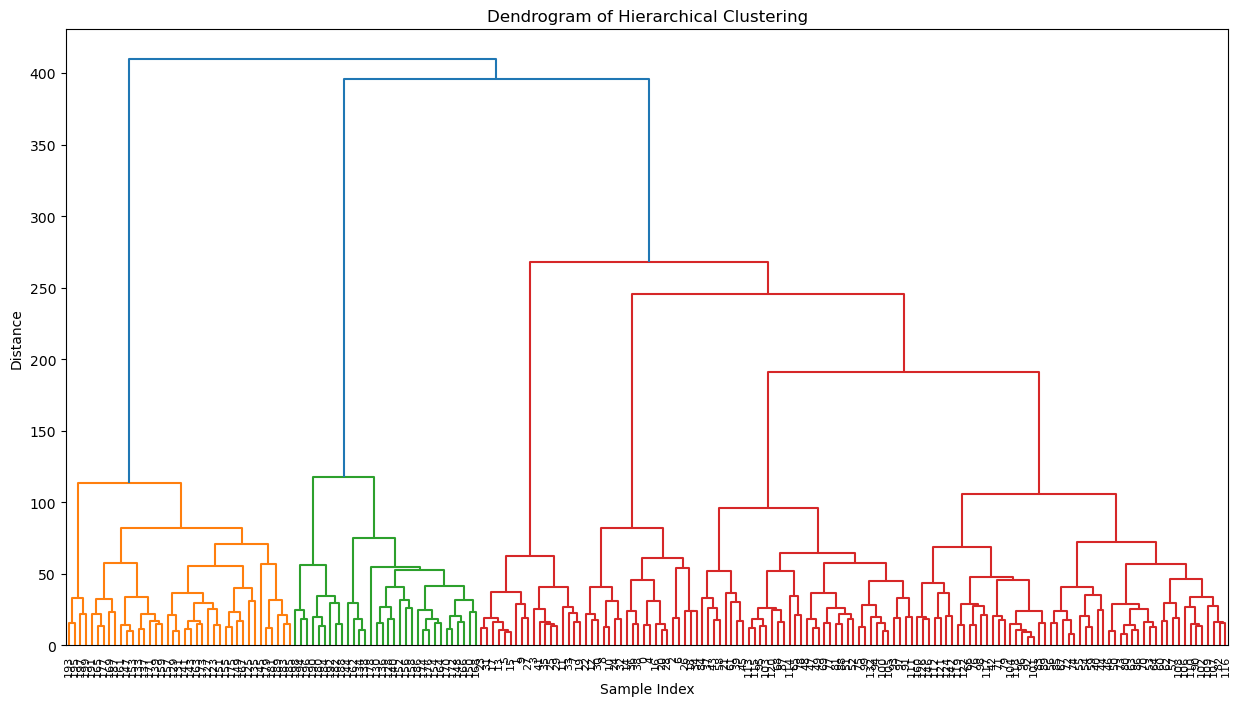

In [35]:
# Calculate the linkage matrix using Ward's method
Z = linkage(features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

From the dendrogram we can identify three main clusters distinguished by color: orange, green and red. The orange cluster is the farest from the other two clusters (it is an independent branch), suggesting that the customer segment is substantially different from the other two. The red cluster is the biggest and contains around 2/3 of the dataset, with several subsegments within it.

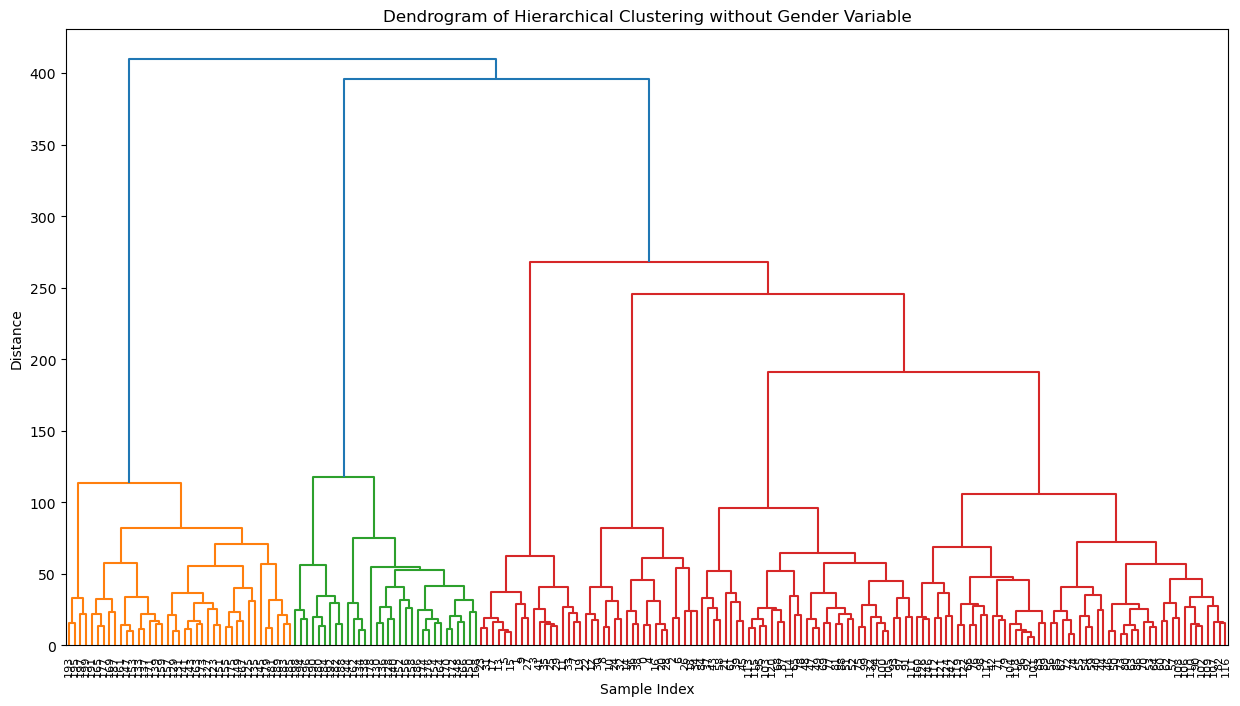

In [36]:
# Calculate the linkage matrix using Ward's method
Z = linkage(noisy_df.iloc[:, 1:8], method='ward') #exlcude gender

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Hierarchical Clustering without Gender Variable') 
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

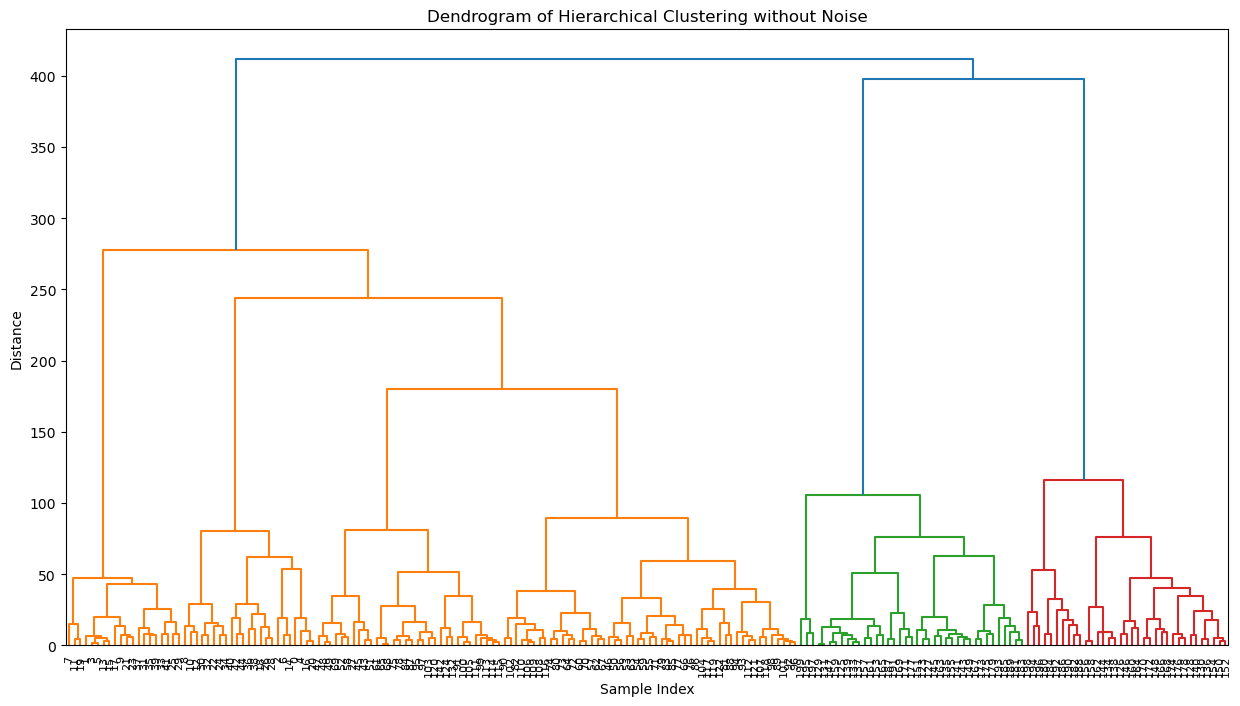

In [37]:
# exclude the noise to see the difference 
# Calculate the linkage matrix using Ward's method
Z = linkage(noisy_df.iloc[:, 0:4], method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Hierarchical Clustering without Noise')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

When we apply variation such as removing the noise or excluding the gender variable, the dendrograms become different. Yet, it's worth mentioning that all the dendrograms have a large branch that covers almost 2/3 of the sample data and two smaller branches